In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Subset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time
import copy

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [33]:
def get_datasets():

    transform_std = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    transform_mnist = transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
    ])

    # Download and load datasets
    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_std)
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_std)

    mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
    mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
    
    datasets = {
        'CIFAR-10': {'train': cifar10_train, 'test': cifar10_test, 'classes': cifar10_train.classes},
        'MNIST': {'train': mnist_train, 'test': mnist_test, 'classes': mnist_train.classes}
    }
    
    return datasets

In [34]:
def get_model(num_classes):

    model = models.alexnet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(9216, 4096)
    model.classifier[4] = nn.Linear(4096, 1024)
    model.classifier[6] = nn.Linear(1024, num_classes)
    
    return model.to(device)

In [35]:
def plot_curves(history, dataset_name, model_name):
    """Plots training & validation accuracy and loss curves."""
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy Curves: {model_name} on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves: {model_name} on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, dataset_name, model_name):
    """Generates and plots a confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name} on {dataset_name}')
    plt.show()

def plot_roc_auc(y_true, y_score, n_classes, classes, dataset_name, model_name):
    """Plots ROC curves and calculates AUC for each class."""

    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC): {model_name} on {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

In [36]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

In [37]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            scores = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            all_scores = torch.cat((all_scores, scores), dim=0)
            
    return all_labels.cpu().numpy(), all_preds.cpu().numpy(), all_scores.cpu().numpy()

In [38]:
def main():
    datasets = get_datasets()
    model_names = ['AlexNet']
    split_sizes = [0.6, 0.7, 0.8]
    num_epochs = 10
    
    for dataset_name, dataset_info in datasets.items():
        print(f"\n{'='*20} DATASET: {dataset_name} {'='*20}")
        train_dataset = dataset_info['train']
        test_dataset = dataset_info['test']
        classes = dataset_info['classes']
        num_classes = len(classes)
        
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        for model_name in model_names:
            print(f"\n{'--'*10} MODEL: {model_name} {'--'*10}")
            
            overall_best_accuracy = 0.0
            best_case_results = {}
            best_split_size = 0
            
            for split in split_sizes:
                print(f"\n--- Training with {int(split*100)}% of data ---")
                
                num_train = len(train_dataset)
                indices = list(range(num_train))
                np.random.shuffle(indices)
                split_idx = int(np.floor(split * num_train))
                train_idx = indices[:split_idx]
                train_subset = Subset(train_dataset, train_idx)
                
                num_subset_train = len(train_subset)
                val_split = 0.2
                val_idx_end = int(np.floor(val_split * num_subset_train))
                val_indices = list(range(num_subset_train))
                np.random.shuffle(val_indices)
                
                final_train_indices = val_indices[val_idx_end:]
                val_indices = val_indices[:val_idx_end]
                
                final_train_subset = Subset(train_subset, final_train_indices)
                val_subset = Subset(train_subset, val_indices)
                
                train_loader = DataLoader(final_train_subset, batch_size=32, shuffle=True)
                val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

                model = get_model(num_classes)
                criterion = nn.CrossEntropyLoss()
                params_to_update = [param for param in model.parameters() if param.requires_grad]
                optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
                
                trained_model, history = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs)
                
                y_true, y_pred, _ = get_predictions(trained_model, test_loader)
                test_accuracy = np.mean(y_true == y_pred)
                print(f"Final Test Accuracy for {int(split*100)}% split: {test_accuracy:.4f}")

                if test_accuracy > overall_best_accuracy:
                    print(f"*** New best model found with accuracy: {test_accuracy:.4f} ***")
                    overall_best_accuracy = test_accuracy
                    best_split_size = split
                    best_case_results['model'] = trained_model
                    best_case_results['history'] = history

            if 'model' in best_case_results:
                print(f"\n--- Generating plots for best case (from {int(best_split_size*100)}% split with {overall_best_accuracy:.4f} accuracy) ---")
                best_model = best_case_results['model']
                best_history = best_case_results['history']
                
                plot_curves(best_history, dataset_name, model_name)
                
                y_true, y_pred, y_score = get_predictions(best_model, test_loader)
                plot_confusion_matrix(y_true, y_pred, classes, dataset_name, model_name)
                plot_roc_auc(y_true, y_score, num_classes, classes, dataset_name, model_name)


==================== DATASET: CIFAR-10 ====================

-------------------- MODEL: AlexNet --------------------

--- Training with 60% of data ---
Epoch 1/10
----------
train Loss: 1.1447 Acc: 0.6015
val Loss: 0.6700 Acc: 0.7653
Epoch 2/10
----------
train Loss: 0.7080 Acc: 0.7493
val Loss: 0.5833 Acc: 0.7963
Epoch 3/10
----------
train Loss: 0.6208 Acc: 0.7817
val Loss: 0.5901 Acc: 0.7970
Epoch 4/10
----------
train Loss: 0.5592 Acc: 0.8025
val Loss: 0.5342 Acc: 0.8133
Epoch 5/10
----------
train Loss: 0.5225 Acc: 0.8168
val Loss: 0.5121 Acc: 0.8208
Epoch 6/10
----------
train Loss: 0.4929 Acc: 0.8251
val Loss: 0.5207 Acc: 0.8205
Epoch 7/10
----------
train Loss: 0.4684 Acc: 0.8306
val Loss: 0.5358 Acc: 0.8143
Epoch 8/10
----------
train Loss: 0.4358 Acc: 0.8431
val Loss: 0.5044 Acc: 0.8233
Epoch 9/10
----------
train Loss: 0.4139 Acc: 0.8498
val Loss: 0.5078 Acc: 0.8288
Epoch 10/10
----------
train Loss: 0.3852 Acc: 0.8639
val Loss: 0.5069 Acc: 0.8338
Best val Acc: 0.833833
Fi

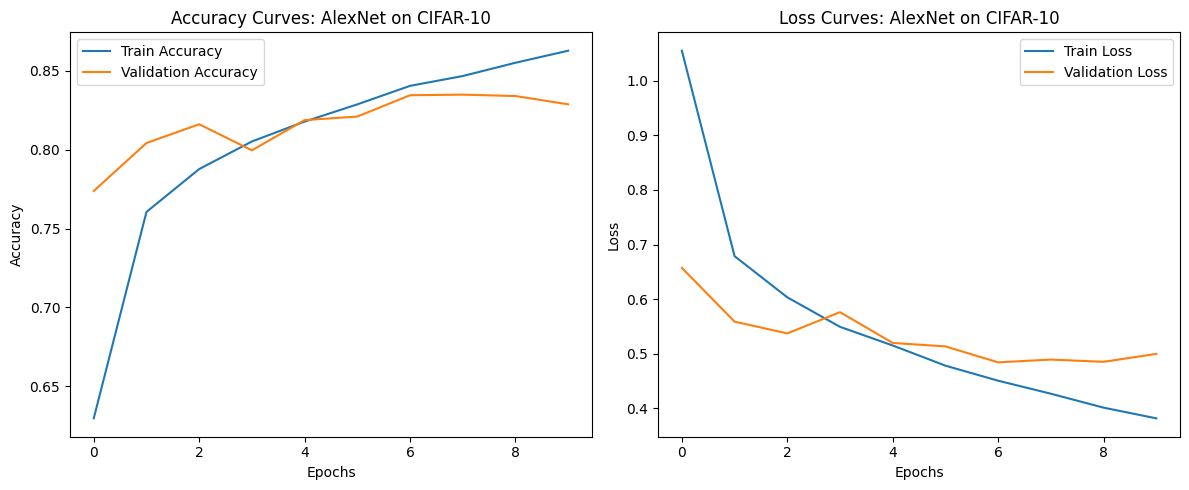

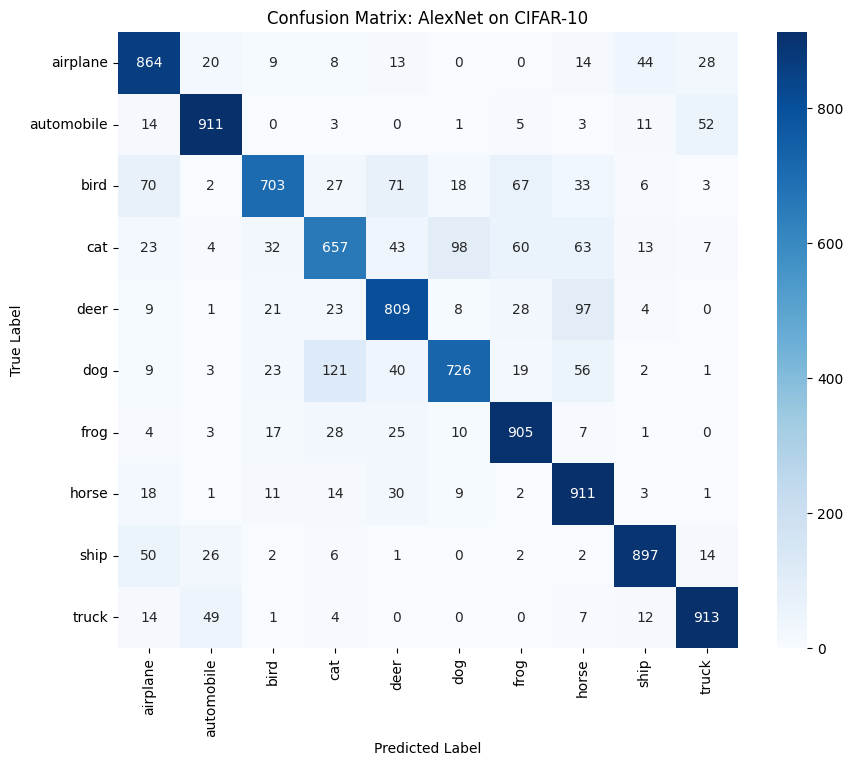

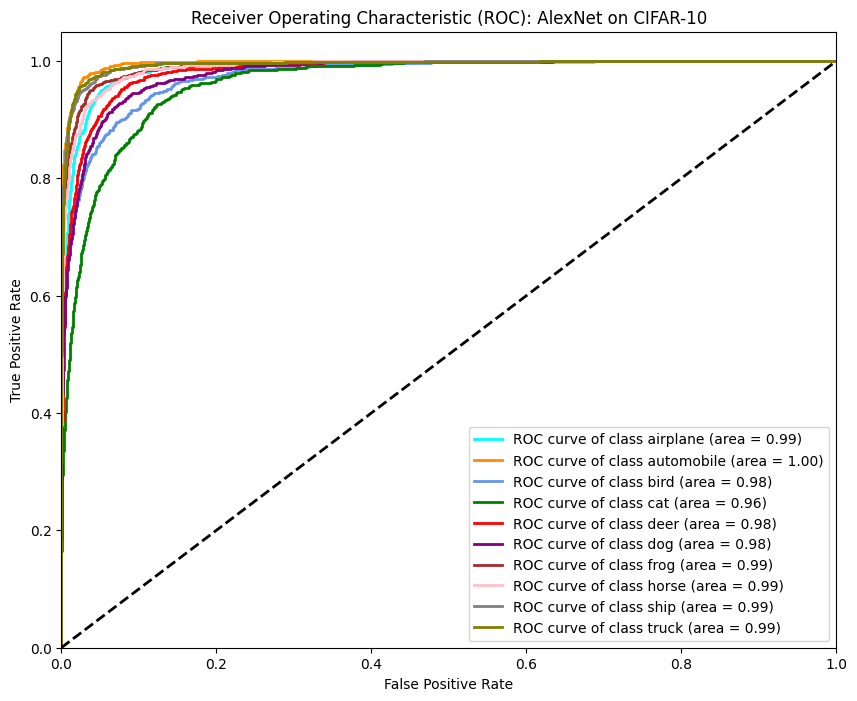


==================== DATASET: MNIST ====================

-------------------- MODEL: AlexNet --------------------

--- Training with 60% of data ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 0.3720 Acc: 0.8998
val Loss: 0.0727 Acc: 0.9772
Epoch 2/10
----------
train Loss: 0.0959 Acc: 0.9707
val Loss: 0.0555 Acc: 0.9846
Epoch 3/10
----------
train Loss: 0.0768 Acc: 0.9757
val Loss: 0.0471 Acc: 0.9861
Epoch 4/10
----------
train Loss: 0.0657 Acc: 0.9793
val Loss: 0.0471 Acc: 0.9878
Epoch 5/10
----------
train Loss: 0.0570 Acc: 0.9814
val Loss: 0.0421 Acc: 0.9879
Epoch 6/10
----------
train Loss: 0.0546 Acc: 0.9833
val Loss: 0.0436 Acc: 0.9867
Epoch 7/10
----------
train Loss: 0.0518 Acc: 0.9830
val Loss: 0.0409 Acc: 0.9890
Epoch 8/10
----------
train Loss: 0.0486 Acc: 0.9848
val Loss: 0.0371 Acc: 0.9900
Epoch 9/10
----------
train Loss: 0.0432 Acc: 0.9861
val Loss: 0.0408 Acc: 0.9889
Epoch 10/10
----------
train Loss: 0.0426 Acc: 0.9857
val Loss: 0.0425 Acc: 0.9881
Best val Acc: 0.990000
Final Test Accuracy for 60% split: 0.9895
*** New best model found with accuracy: 0.9895 ***

--- Training with 70% of data ---
Epoch 1/10
----------
train 

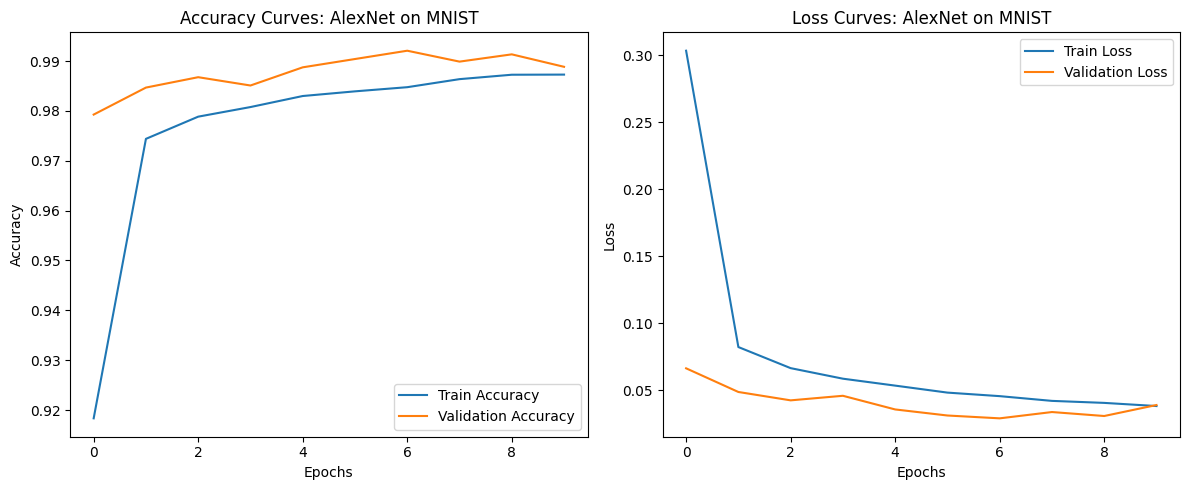

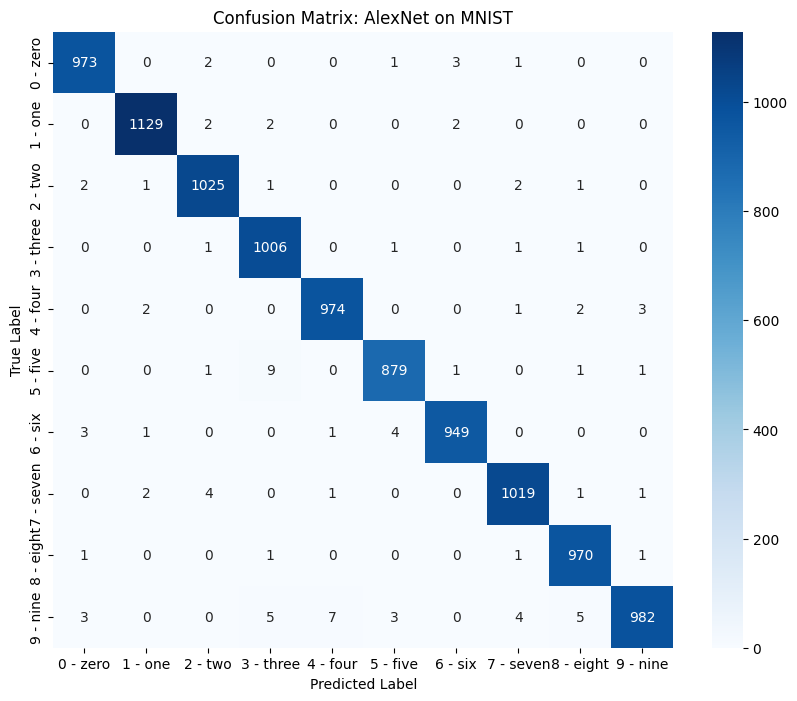

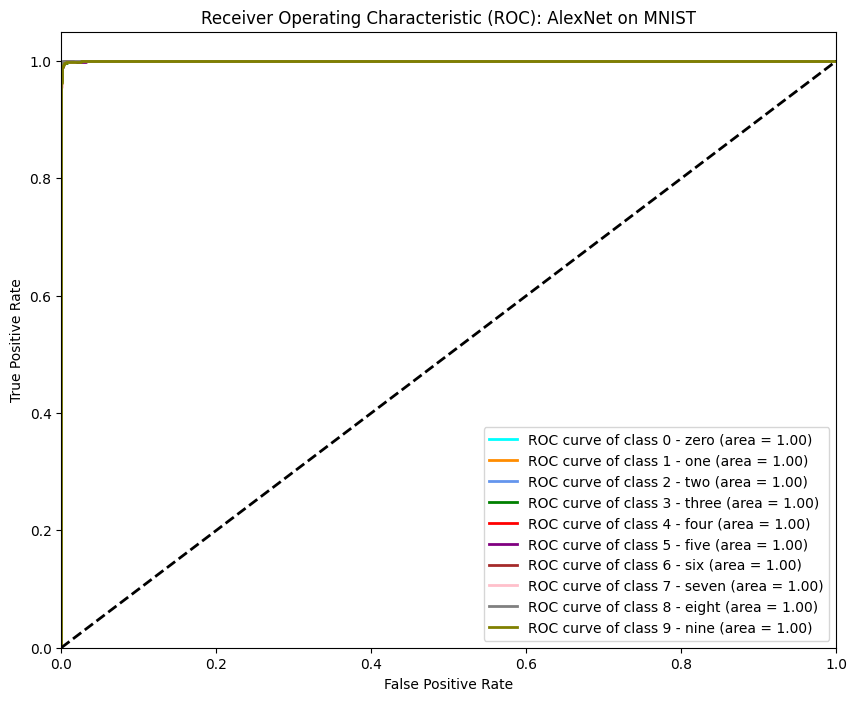

In [39]:
if __name__ == '__main__':
    main()